In [4]:
%pylab inline
import pandas as pd
import numpy as np
import time

Populating the interactive namespace from numpy and matplotlib


In [12]:
def processOfflineTrain(file):
    offline = pd.read_csv(file, header=None)
    offline.columns = ['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance', 'Date_received', 'Date']
    offline = offline[offline['Coupon_id'] != 'null']
    offline['result'] = [0] * len(offline)

    #将日期转化为星期
    offline['week'] = offline['Date_received'].apply(lambda x: time.strptime(str(x), '%Y%m%d')[6])

    #计算用户消费优惠券间隔天数
    cost = offline[offline['Date'] != 'null']
    offline['days'] = cost['Date'].apply(lambda x: int(time.strptime(str(x), '%Y%m%d')[7])) - \
                      cost['Date_received'].apply(lambda x: int(time.strptime(str(x), '%Y%m%d')[7]))
    offline['days'] = offline['days'].fillna(1000)

    #计算每条数据是否在规定日期内使用优惠券，1为正样本，0为负样本
    offline['result'] = offline[offline['days'] <= 15]['days'].apply(lambda x: 1)
    offline['result'] = offline['result'].fillna(0)
    
    #Distance为null,设为11
    offline['Distance'] = offline['Distance'].map(lambda x:11 if x=='null' else x)
    #不成熟的想法，运算速度奇慢
    # for i in xrange(len(offline)):
    #     if offline['Date_received'][i] != 'null':
    #         receivedDay = time.strptime(offline['Date_received'][i], '%Y%m%d')
    #         offline['week'][i] = receivedDay[6]
    #         if offline['Date'][i] != 'null':
    #             dateDay = time.strptime(offline['Date'][i], '%Y%m%d')
    #             offline['days'][i] = int(dateDay[7])-int(receivedDay[7])
    #             if offline['days'][i] <= 15: offline['result'][i] = 1
    #             print i, offline['days'][i]

    offline[['week', 'days', 'result', 'Distance']] = offline[['week', 'days', 'result', 'Distance']].astype(int)
    # print offline.loc[:100, ['Date_received', 'Date', 'week', 'days', 'result']]
    return offline

In [127]:
offline = processOfflineTrain('ccf_offline_stage1_train.csv')

In [20]:
#折扣率频率
def processOfflineDiscountRate(offline):
    discountDict = {}
    discountRate = set(offline['Discount_rate'])
    for d in discountRate:
        discountDict[d] = 0
        discount = offline[offline['Discount_rate'] == d]
        totalSended = len(discount)
        totalCosted = len(discount[discount['Date'] != 'null'])
        rate = float(totalCosted) / totalSended

        discountDict[d] = [totalSended, totalCosted, rate]

    return discountDict

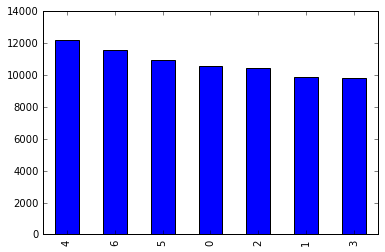

In [30]:
offline[offline['Date']!='null']['week'].value_counts().plot(kind='bar')

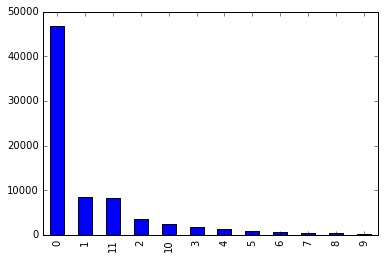

In [31]:
offline[offline['Date']!='null']['Distance'].value_counts().plot(kind='bar')

In [150]:
def generateFeatures(offline):
    userDict = {}
    merchantDict = {}
    discountDict = {}
    
    ufile = file('userId.txt', 'r')
    for line in ufile:
        d = line.split()
        userDict[d[0]] = d[3]
    ufile.close()
    
    mfile = file('merchantId.txt', 'r')
    for line in mfile:
        d = line.split()
        merchantDict[d[0]] = d[3]
    mfile.close()
    
    dfile = file('discount.txt', 'r')
    for line in dfile:
        d = line.split()
        discountDict[d[0]] = d[3]
    dfile.close()
    
    offline['userRate'] = offline['User_id'].map(lambda x: userDict[str(x)])
    offline['merchantRate'] = offline['Merchant_id'].map(lambda x: merchantDict[str(x)])
    offline['discountRate'] = offline['Discount_rate'].map(lambda x: discountDict[str(x)])
    
    features = offline.drop(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Date_received', 'Date', 'days'], 
                         axis=1)
    features[['userRate', 'merchantRate', 'discountRate']] = features[['userRate', 'merchantRate', 'discountRate']].astype(float)
    
    features.to_csv('offlineTrainfeatures.csv')
    return features

In [151]:
features = generateFeatures(offline)

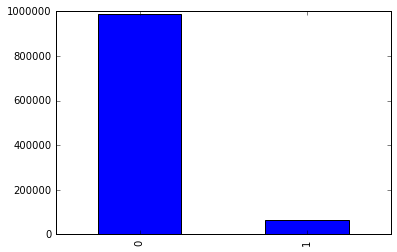

In [135]:
offline['result'].value_counts().plot(kind='bar')

In [132]:
offline.dtypes

User_id           int64
Merchant_id       int64
Coupon_id        object
Discount_rate    object
Distance          int64
Date_received    object
Date             object
result            int64
week              int64
days              int64
userRate         object
merchantRate     object
discountRate     object
dtype: object

In [138]:
features = offline.drop(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Date_received', 'Date', 'days'], 
                         axis=1)

In [139]:
features.dtypes

Distance         int64
result           int64
week             int64
userRate        object
merchantRate    object
discountRate    object
dtype: object

In [141]:
offline.dtypes

User_id           int64
Merchant_id       int64
Coupon_id        object
Discount_rate    object
Distance          int64
Date_received    object
Date             object
result            int64
week              int64
days              int64
userRate         object
merchantRate     object
discountRate     object
dtype: object